# Initializations

In [1]:
import numpy as np
import pandas as pd

import sys, os, time
import glob

from matplotlib import pyplot as plt
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from skimage.io import imread, imsave

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.utils as vutils

# Set up data sources

In [2]:
dataroot = "/home/adalbert/data/world-cities/"

#### Training data is in ./train (all cities > 10k population)

In [3]:
import glob

files = glob.glob(dataroot + "/train/*/*.png")
files_df = []
for f in files:
    s = f.split("/")
    fname, cls = s[-1], s[-2]
    _,country,city,_,pop,lat,lon = fname.split("_")
    files_df.append((f, cls, country, pop))
    
files_df = pd.DataFrame(files_df, \
                columns=["filename", "class", "country", "population"])

len(files_df)

24986

#### Preprocessing: assign class of "built area"
- by deciles

In [4]:
from skimage.io import imread

def compute_built_area(f):
    img = imread(f)
    img[img==128] = 0
    return (img > 0).sum() / float(img.shape[0]*img.shape[1])

files_df['built pct'] = files_df['filename'].apply(compute_built_area)

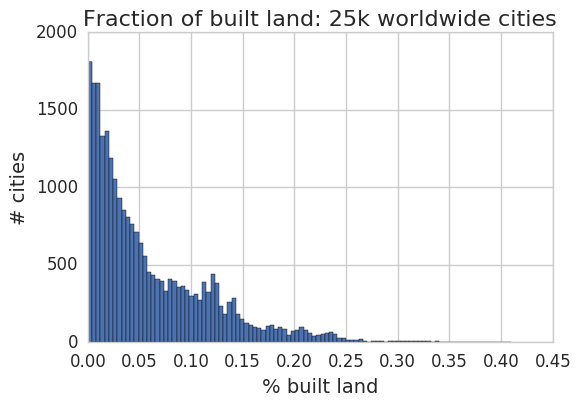

In [5]:
files_df['built pct'].hist(bins=100, figsize=(6,4))
sns.set_style("whitegrid", {'axes.grid' : False})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Fraction of built land: 25k worldwide cities", fontsize=16)
plt.xlabel("% built land", fontsize=14)
plt.ylabel("# cities", fontsize=14)

In [6]:
q = files_df['built pct'].quantile(np.linspace(0.1,1,10))
files_df['decile'] = files_df['built pct'].apply(lambda x: np.searchsorted(q.values, x) )

#### Split into training and validation

In [7]:
idx = np.random.choice(range(len(files_df)), int(len(files_df)*0.95), \
                       replace=False)
train_df = files_df.iloc[idx]
valid_df  = files_df.iloc[list(set(range(len(files_df))) - set(idx))]

train_df.to_csv(dataroot + "/train.csv")
valid_df.to_csv(dataroot + "/valid.csv")

len(train_df), len(valid_df)

(23736, 1250)

#### Test data is under ./test/ and contains more carefully-filtered samples

In [8]:
import glob

files = glob.glob(dataroot + "/test/*/*.png")
test_df = []
for f in files:
    s = f.split("/")
    fname, cls = s[-1], s[-2]
    _,country,city,_,pop,lat,lon = fname.split("_")
    test_df.append((f, cls, country, pop))
    
test_df = pd.DataFrame(test_df, \
                columns=["filename", "class", "country", "population"])

len(test_df)

3012

In [80]:
test_df['built pct'] = test_df['filename'].apply(compute_built_area)
test_df['decile'] = test_df['built pct'].apply(lambda x: np.searchsorted(q.values, x) )
test_df['city'] = test_df['filename'].apply(lambda s: os.path.basename(s).split("_")[2].replace("-"," "))

test_df.to_csv(dataroot + "/test.csv")


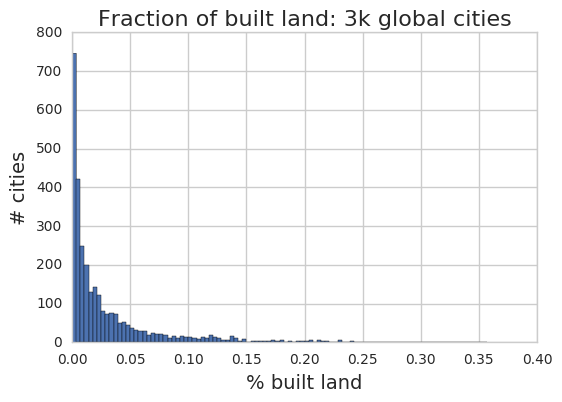

In [10]:
test_df['built pct'].hist(bins=100, figsize=(6,4))
plt.title("Fraction of built land: 3k global cities", fontsize=16)
plt.xlabel("% built land", fontsize=14)
plt.ylabel("# cities", fontsize=14)

# Train GAN -- done externally
We could spawn external process, but better just copy the command into an external script and run in a separate terminal. 

In [ ]:
import sys
sys.path.append("/home/adalbert/nbserver/urbanization-patterns/models/pytorch_utils")
from loader_dataframe import ImageDataFrame, grayscale_loader, default_loader

In [ ]:
val_nodata = 128

pimg = grayscale_loader(test_df['filename'].iloc[0])

plt.imshow(pimg)

Set some variables used throughout

In [254]:
nz   = 100
ngf  = 64
nc   = 1
imageSize = 64
batchSize = 64
workers   = 4

# Plot fake and real samples

In [11]:
# experiment_dir = "/home/adalbert/nbserver/pytorch-workspace/DCGAN/25k-cities-128/"

experiment_dir = "/home/adalbert/nbserver/pytorch-workspace/DCGAN/25k-64-z-shift-2/"


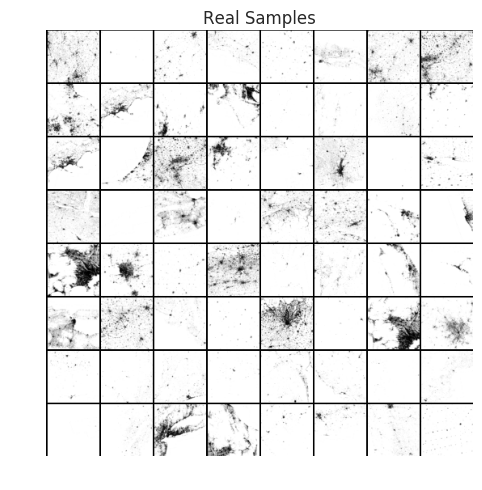

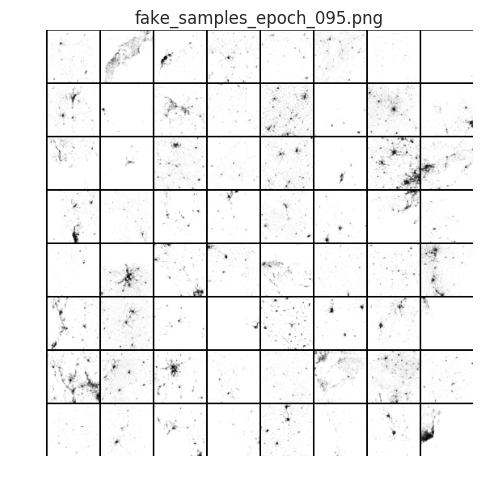

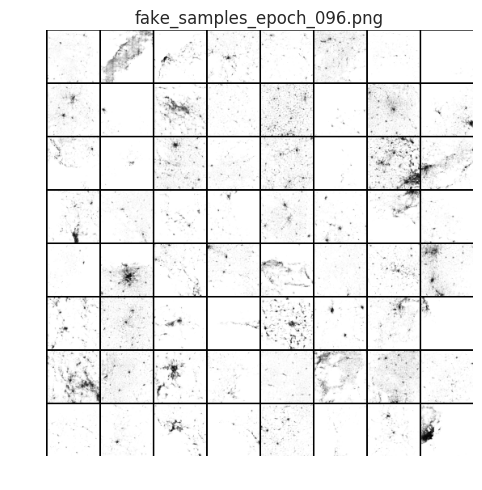

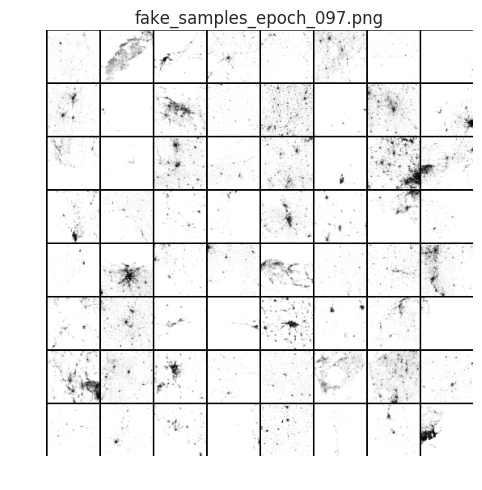

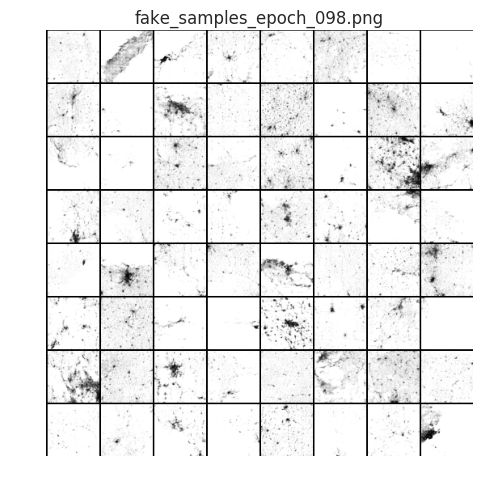

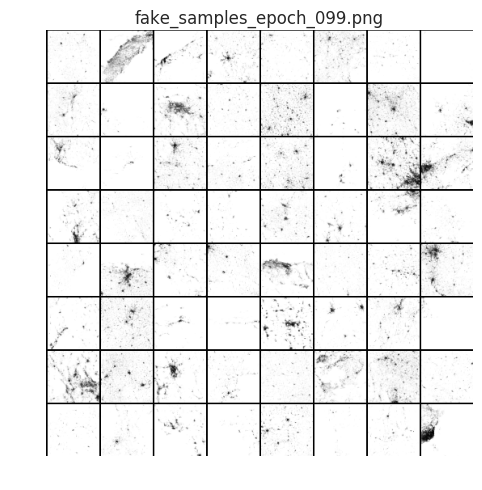

In [58]:
files_fake = glob.glob(experiment_dir + "/fake*.png")
files_fake.sort(key=lambda x: int(os.path.basename(x).split("_")[-1].replace(".png","")))

files_real = glob.glob(experiment_dir + "/real*.png")

img_real = imread(files_real[0])
img_real = img_real / float(img_real.max())
plt.imshow(1-np.abs(img_real))
plt.title("Real Samples")
plt.axis("off")
plt.show()

for f in files_fake[-5:]:
    img = imread(f)
    img = img / float(img.max())
    plt.imshow(1 - np.abs(img))
    plt.title(os.path.basename(f))
    plt.axis("off")
    plt.show()


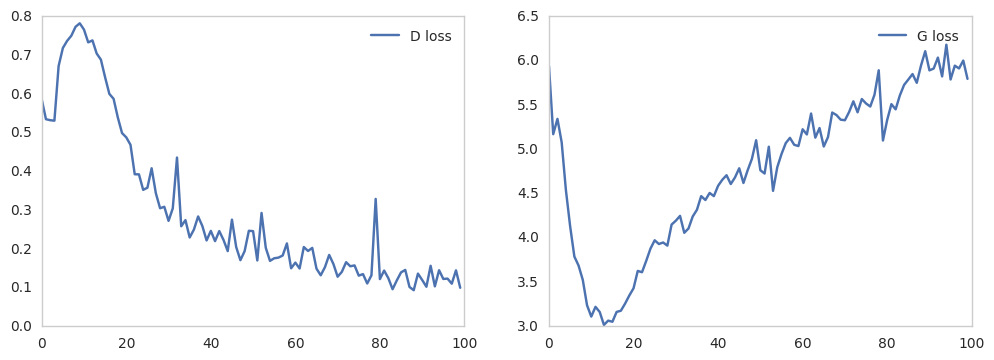

In [57]:
import cPickle as pickle
import gzip

with gzip.open(experiment_dir + "./training-loss.pickle.gz", "r") as f:
    lossD, lossG = pickle.load(f)
    
lossD = np.array(lossD)
lossG = np.array(lossG)

# plot
fig,ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(lossD[:,0], label="D loss")
ax[0].legend()
ax[1].plot(lossG[:,0], label="G loss")
ax[1].legend()

# Explore latent space 
 - a way to assess representation quality introduced in the DCGAN paper

#### Load last checkpointed generator model

In [59]:
files_cptG = glob.glob(experiment_dir + "/netG*.pth")
files_cptG = {int(os.path.basename(f).split(".")[0].split("_")[-1]):f \
              for f in files_cptG}

In [376]:
sys.path.append("../models/")
import models.dcgan_orig as do

ngpu = 2
netG = do._netG(ngpu, nc, nz, ngf)

netG.load_state_dict(torch.load(files_cptG[np.argmax(files_cptG.keys())]))
# if torch.cuda.is_available():
#     netG.cuda()

#### Generate interpolation map

In [368]:
def generate_interpolation_map(Z,M):
    N, nz = Z.shape
    Z_map = np.zeros((N-1,M+1,nz))
    for n in range(N-1):
        dZ = (Z[n+1,:] - Z[n,:]) / float(M)
        for m in range(M+1):
            Z_map[n,m,:] = Z[n,:] + m*dZ
    Z_map = Z_map.reshape(((N-1)*(M+1), nz))
    return Z_map

def generate_samples(Z, cuda=False):
    N, nz = Z.shape
    Zv = torch.FloatTensor(Z.reshape(N, nz, 1, 1))
    if cuda:
        Zv = Zv.cuda()
    Zv = Variable(Zv)
    fake = netG(Zv)
    return fake

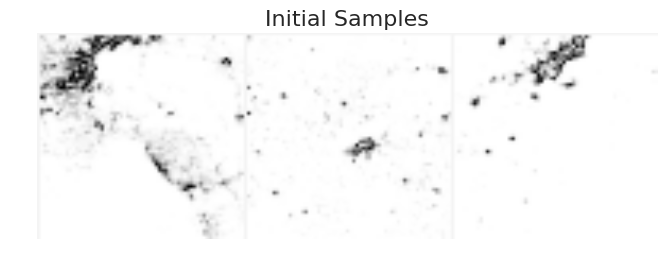

In [65]:
N = 3

Z = np.random.randn(N, nz)
fake = generate_samples(Z)

canvas = vutils.make_grid(fake.data, nrow=M-1, padding=1).numpy()

plt.figure(figsize=(8,4))
plt.imshow(1-np.abs(canvas[0,:,:]))
plt.axis("off")
plt.title("Initial Samples", fontsize=16)

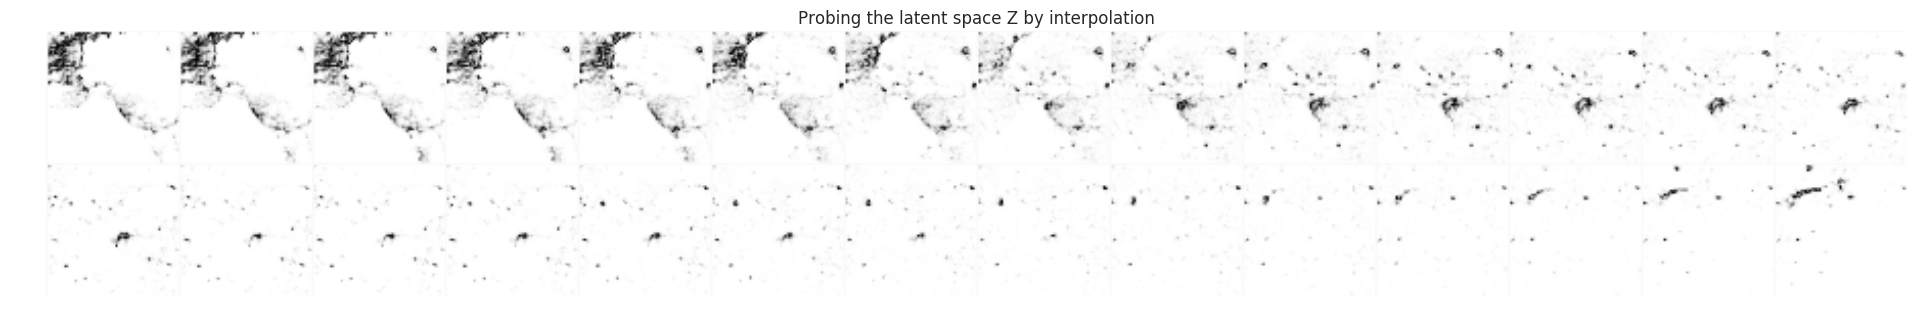

In [66]:
M = 15

Z_map = generate_interpolation_map(Z, M)
fake = generate_samples(Z_map)

canvas = vutils.make_grid(fake.data, nrow=M-1, padding=1).numpy()

plt.figure(figsize=(24,10))
plt.imshow(1-np.abs(canvas[0,:,:]))
plt.axis("off")
plt.title("Probing the latent space Z by interpolation")

#### Generate synthetic samples with given amount of zeros

511.574552602 990 (10, 100)


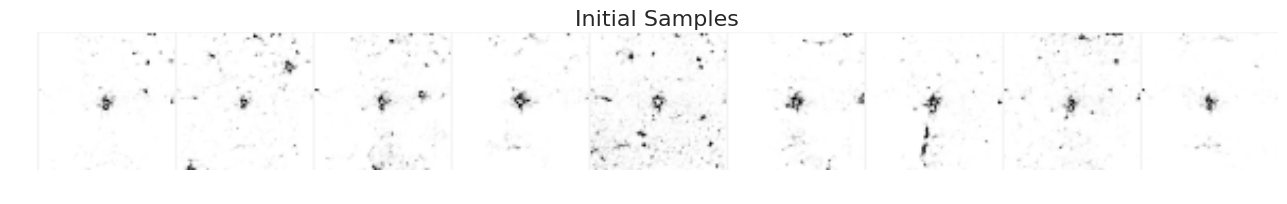

In [67]:
N = 10
M = 10
p = 0.01 # amount of zeros

Z = np.random.rand(N, nz)
idx = np.random.choice(range(nz), size=int(nz*p), replace=False)
Z[:,idx] = 0
#Z = Z * p 

print Z.sum(), (Z>0).sum(), Z.shape

fake = generate_samples(Z)

canvas = vutils.make_grid(fake.data, nrow=M-1, padding=1).numpy()

plt.figure(figsize=(16,4))
plt.imshow(1-np.abs(canvas[0,:,:]))
plt.axis("off")
plt.title("Initial Samples", fontsize=16)

# Extract features for test samples

#### Load discriminator

In [31]:
# get checkpoints

files_cptD = glob.glob(experiment_dir + "/netD*.pth")
files_cptD = {int(os.path.basename(f).split(".")[0].split("_")[-1]):f \
              for f in files_cptD}

last_checkpoint = files_cptD[np.argmax(files_cptD.keys())]

In [250]:
sys.path.append("../models/")
import models.dcgan_orig as do

ngpu = 2
netD = do._netD(ngpu, nc, ndf)

netD.load_state_dict(torch.load(last_checkpoint))
if torch.cuda.is_available():
    netD.cuda()

feature_extractor = nn.Sequential(*list(list(netD.children())[0].children())[:-2])

#### Set up test data sources

In [33]:
sys.path.append("./../models/pytorch_utils")
from loader_dataframe import ImageDataFrame, grayscale_loader
import torchvision.transforms as transforms

test_df = pd.read_csv(dataroot + "/test.csv")

dataset = ImageDataFrame(df=test_df, classCol='built pct',
                         loader=grayscale_loader,
                         transform=transforms.Compose([
                               transforms.Scale(imageSize),
                               transforms.CenterCrop(imageSize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

assert dataset

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
                                     shuffle=False, num_workers=int(workers))


#### Extract features from discriminator

In [293]:
from torch.autograd import Variable

def extract_features(feature_extractor, X):
    '''
    X is a list of data batches or a generator (dataloader).
    '''
    input = torch.FloatTensor(batchSize, nc, imageSize, imageSize)
    if torch.cuda.is_available():
        input = input.cuda()
    input = Variable(input)

    labels = []
    features = []
    for i, data in enumerate(X):
        feature_extractor.zero_grad()
        real_cpu, lab_batch = data
        batch_size = real_cpu.size(0)
        input.data.resize_(real_cpu.size()).copy_(real_cpu)
        feat_batch = feature_extractor(input)
        feat_batch = feat_batch.data.cpu().numpy().reshape((batch_size,-1))

        features.append(feat_batch)
        if lab_batch is not None:
            lab_batch = lab_batch.numpy()
        labels.append(lab_batch)

    features = np.vstack(features)
    labels = np.hstack(labels)
    
    return features, labels

features, labels = extract_features(feature_extractor, dataloader)

In [ ]:
# import cPickle as pickle
# import gzip

# with gzip.open("test_set_features.pickle.gz", "r") as f:
#     features = pickle.load(f)

In [38]:
import cPickle as pickle
import gzip

with gzip.open("test_set_features.pickle.gz", "w") as f:
    pickle.dump(features, f)

# Generate lots of synthetic samples
- pass them through the Discriminator to obtain features

In [377]:
N = 100000
Z = np.random.randn(N, nz)

fake = generate_samples(Z, cuda=False)
# img_fake = fake.data.numpy().squeeze()

n_batches = int(np.ceil(float(N)/batchSize))
fake_batches = [(fake.data[(i*batchSize):min([N,((i+1)*batchSize)])], None) \
                for i in range(n_batches)]

In [378]:
img_fake = fake.data.numpy().squeeze()
img_fake = 1 - np.abs(img_fake)

In [379]:
features_fake, labels_fake = extract_features(feature_extractor, fake_batches)

features_fake.shape

(100000, 8192)

In [380]:
features_fake.shape

(100000, 8192)

# Project to low-d embedding space via t-SNE

In [ ]:
from sklearn import decomposition
N_PCA = 50

pca = decomposition.PCA(n_components=N_PCA)

feats_pca = pca.fit_transform(features)[:,:N_PCA]

plt.figure(figsize=(4,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("PCA Components Variance Explained")
plt.xlabel("# components")
plt.ylabel("% variance")

In [40]:
# https://github.com/DmitryUlyanov/Multicore-TSNE

from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_jobs=32, perplexity=30, n_components=20)
feats_tsne = tsne.fit_transform(features.astype(np.float64))

In [ ]:
feats_tsne.shape

# Similar image search: real cities

In [222]:
from scipy.spatial import cKDTree
from sklearn.neighbors import KDTree, BallTree

myfeatures = features # feats_tsne

tree = KDTree(features)

In [318]:
# mycities = ["barcelona, es", "athens, gr", "berlin, de", "boston, us", "san francisco, us"]
mycities = ["kano, ng", "shreveport, us", "berlin, de", "hyderabad, in", "salt lake city, us"]
sel_df = test_df[test_df['city'].apply(lambda s: sum([x in s for x in mycities])>0)]

feats_sel = myfeatures[sel_df.index,:]

n_examples = 5
_, neighbors = tree.query(feats_sel, k=n_examples)

In [319]:
from skimage.io import imread
from skimage.transform import resize

# create canvass
canvass = []
for city0,f0,idx in zip(sel_df['city'], sel_df['filename'], neighbors):
    img0 = imread(f0)
    row = [np.pad(resize(img0, (100,100)), (2,2), "constant")]
    for _,r in test_df.ix[idx[1:]].iterrows():
        img = imread(r['filename'])
        row.append(np.pad(resize(img, (100,100)), (2,2), "constant"))
    canvass.append(np.hstack(row))
canvass = np.vstack(canvass)

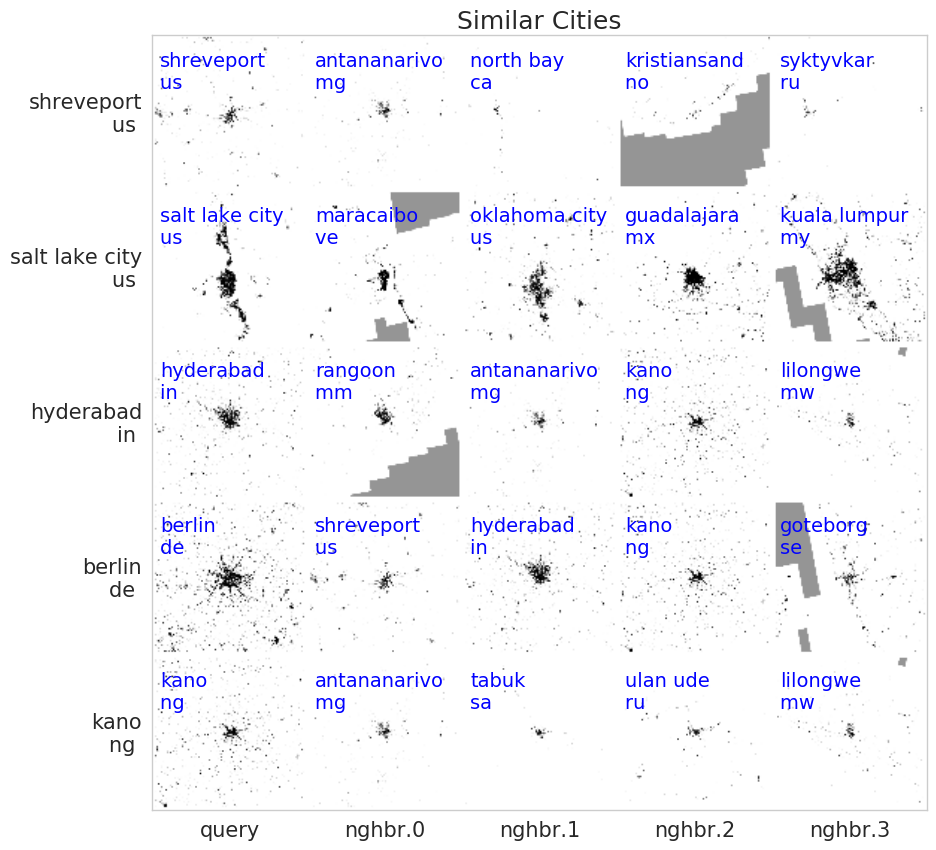

In [320]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

# plot
plt.figure(figsize=(20,10))
plt.imshow(canvass)
plt.yticks([])
plt.yticks([52 + i * 104 for i in range(len(sel_df))], [x.split("(")[0].replace(", ", "\n") for x in sel_df['city']])
plt.xticks([52 + i * 104 for i in range(n_examples)], ["query"] + ["nghbr.%d"%i for i in range(n_examples)])
plt.title("Similar Cities")

for i,(city0,f0,idx) in enumerate(zip(sel_df['city'], sel_df['filename'], neighbors)):
    for j,(_,r) in enumerate(test_df.ix[idx].iterrows()):
        city1 = r['city']
        plt.annotate(city1.split("(")[0].replace(", ", "\n"), 
                     xy=(5 + j * 104, 35 + i * 104), 
                     xytext=(5 + j * 104, 35 + i * 104),
                     fontsize=14, color="blue")

# Search similar images: simulations

In [381]:
tree_fake = KDTree(features_fake)

In [394]:
# mycities = ["barcelona, es", "athens, gr", "berlin, de", "boston, us", "san francisco, us"]
mycities = ["lagos, ng", "hyderabad, in", "salt lake city, us", "boston, us", "san francisco, us"]
sel_df = test_df[test_df['city'].apply(lambda s: sum([x in s for x in mycities])>0)]

feats_sel = features[sel_df.index,:]

n_examples = 5
_, neighbors = tree_fake.query(feats_sel, k=n_examples, breadth_first=True)

In [395]:
# create canvass
canvass = []
for city0,f0,idx in zip(sel_df['city'], sel_df['filename'], neighbors):
    img0 = imread(f0)
    row = [np.pad(resize(img0, (100,100)), (2,2), "constant")]
    for img in img_fake[idx,:]:
        row.append(np.pad(resize(img, (100,100)), (2,2), "constant"))
    canvass.append(np.hstack(row))
canvass = np.vstack(canvass)

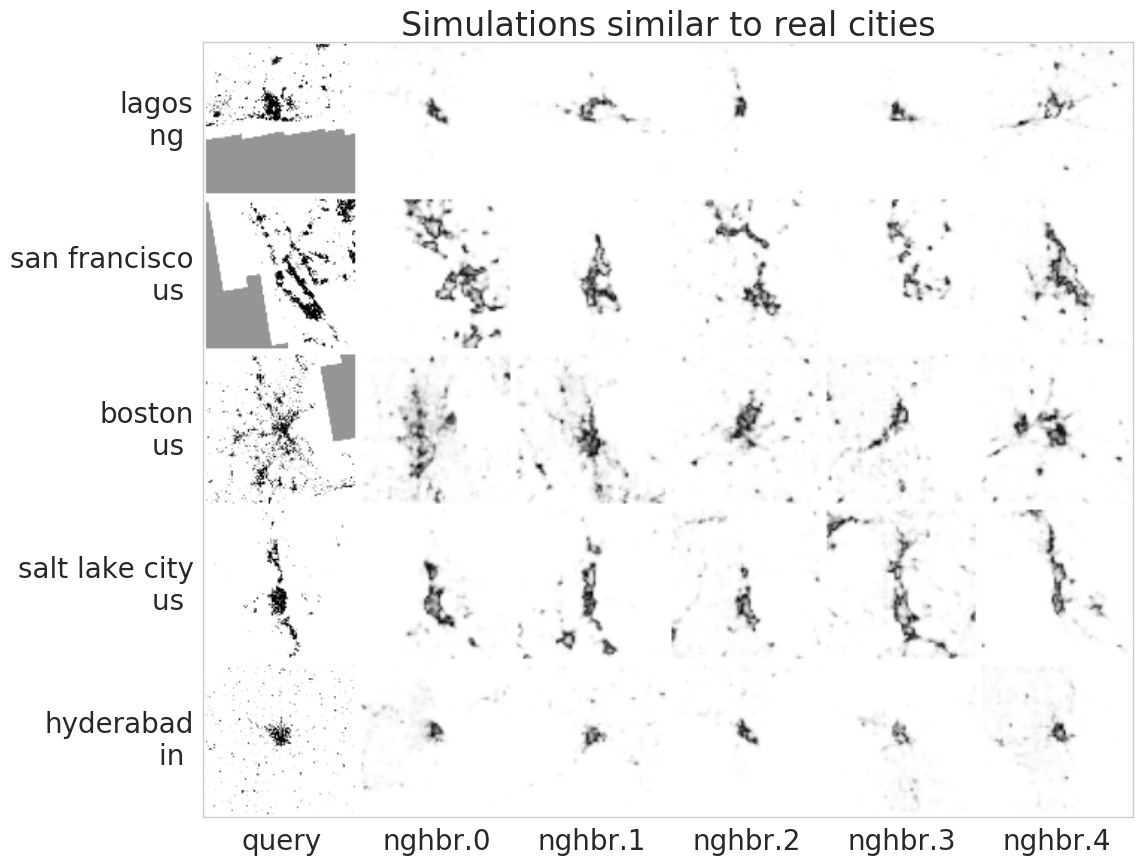

In [396]:
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 1})

# plot
plt.figure(figsize=(20,10))
plt.imshow(canvass)
plt.yticks([])
plt.yticks([52 + i * 104 for i in range(len(sel_df))], \
           [x.split("(")[0].replace(", ", "\n") for x in sel_df['city']])
plt.xticks([52 + i * 104 for i in range(n_examples+1)], \
           ["query"] + ["nghbr.%d"%i for i in range(n_examples)])
plt.title("Simulations similar to real cities")
plt.show()

# Compute "similarity network" between cities

In [401]:
A = np.zeros((len(test_df), len(test_df)))

all_cities = test_df['city']

for i,c in enumerate(all_cities):
    clear_output(wait=True)
    print i, '/', len(all_cities)
    dist, neighbors = tree.query([features[i,:]], k=100)
    A[i,neighbors[0]] = dist[0]

3011 / 3012


In [404]:
(A>0).sum() / float(A.size)

0.032868525896414341

# Clustering test samples

In [41]:
from sklearn.cluster import KMeans

feats_reduced = feats_tsne #feats_pca

loss_vec = []
k_vec = np.linspace(5, 100, 40)
for k in k_vec:
    print int(k),
    kmeans = KMeans(n_clusters=int(k), random_state=0).fit(feats_reduced)
    loss = -kmeans.score(feats_reduced)
    loss_vec.append(loss)

5 7 9 12 14 17 19 22 24 26 29 31 34 36 39 41 43 46 48 51 53 56 58 61 63 65 68 70 73 75 78 80 82 85 87 90 92 95 97 100


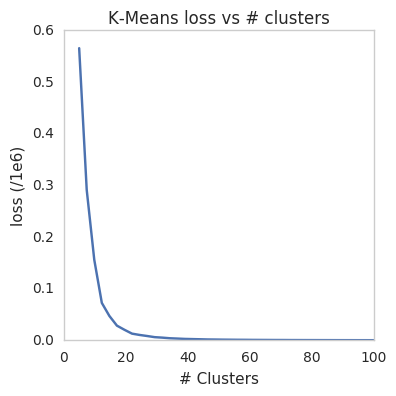

In [42]:
plt.figure(figsize=(4,4))
plt.plot(k_vec, np.array(loss_vec)/1e6)
plt.title("K-Means loss vs # clusters")
plt.xlabel("# Clusters")
plt.ylabel("loss (/1e6)")

In [53]:
K_opt = 25
kmeans = KMeans(n_clusters=K_opt, random_state=0).fit(feats_tsne)

C = kmeans.predict(feats_tsne)

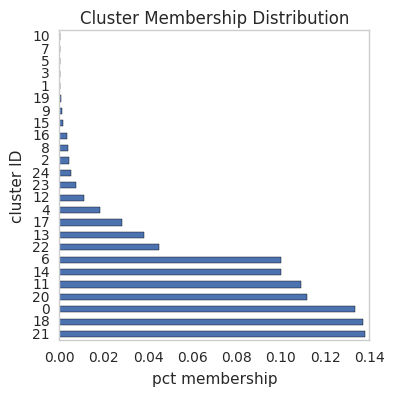

In [54]:
(pd.Series(C).value_counts() / float(len(C))).plot(kind="barh", figsize=(4,4))
plt.title("Cluster Membership Distribution")
plt.xlabel("pct membership")
plt.ylabel("cluster ID")

In [55]:
def plot_examples(image_paths, labels, classes=None, \
                  nExamples=10, thumbSize = (64,64), pad_pix=2, title="example"):
    # build example canvass 
    from skimage.transform import resize
    from skimage.io import imread
    
    clustLabels = np.unique(labels)
    nClusters = clustLabels.size
    canvas = np.ones(((thumbSize[0]+pad_pix)*nClusters, nExamples*(thumbSize[1]+pad_pix)))
    for i,c in enumerate(clustLabels):
        cur_class_samples = np.where(labels==c)[0]
        idx = np.random.choice(cur_class_samples, replace=False, size=min([nExamples, len(cur_class_samples)]))
        for j in range(len(idx)):
            img = imread(image_paths[idx[j]])
            img = img / float(img.max())
            img[abs(img-0.5)<0.01] = 0 # hack to remove no-data patches
            # img = 1-img
            img = resize(img, thumbSize)
            canvas[i*(thumbSize[0]+pad_pix):(i*pad_pix + (i+1)*thumbSize[0]), 
                   j*(thumbSize[1]+pad_pix):(j*pad_pix + (j+1)*thumbSize[1])] = img
    
    # plot examples of each class
    fig,ax = plt.subplots(1, figsize=(12,10))
    plt.tight_layout()
    print canvas.shape
    ax.imshow(canvas.swapaxes(0,1))#, aspect='auto')
    ax.set_title(title, fontsize=18)
    ax.set_ylabel("-- examples --", fontsize=16)
    ax.set_xlabel("-- land classes --", fontsize=16)
    # Turn off tick labels
    if classes is None: classes = clustLabels
    ax.set_xticks([thumbSize[0]*(0.5 + x) for x in range(nClusters)])
    ax.set_xticklabels(classes, fontsize=16, rotation=90)
    ax.set_yticklabels([])
    #plt.axis("off")
    plt.show()

(1650, 660)


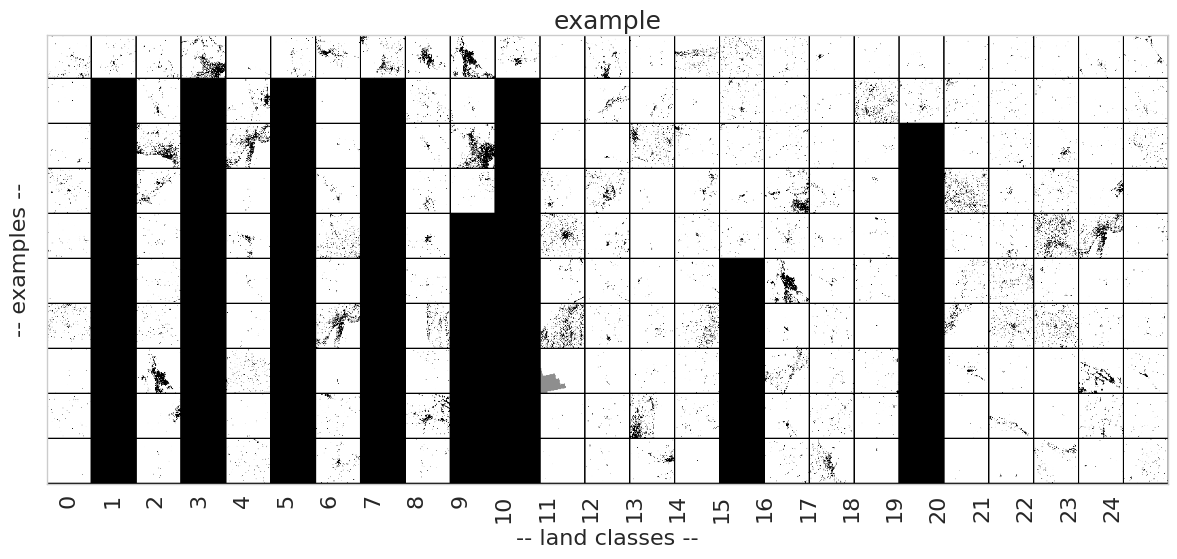

In [56]:
plot_examples(test_df['filename'].values, C)

# Visualize clusters
- linear grid assignment visualization

#### Standard t-SNE point clouds labeled for the clusters identified by K-Means

In [ ]:
import seaborn as sns
import matplotlib.patheffects as PathEffects

def labeled_scatterplot(x, labels, palette=None, ax=None, add_text=True, alpha=None, figsize=None):
    
    classes = np.unique(labels)
    class_dict = {c:i for i,c in enumerate(classes)}
    n_clust = len(classes)    
    colors = [palette[l] for l in labels]

    # We create a scatter plot.
    if ax is None:
        f = plt.figure(figsize=figsize)
        ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=colors, alpha=alpha)
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    if add_text:
        # We add the labels for each class.
        txts = []
        for k,c in enumerate(classes):
            # Position of each label.
            xtext, ytext = np.median(x[labels == c, :], axis=0)
            txt = ax.text(xtext, ytext, str(c), fontsize=24)
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=5, foreground=palette[c]),
                PathEffects.Normal()])
            txts.append(txt)

    return ax

In [ ]:
tsne = TSNE(n_jobs=32, perplexity=30, n_components=2)
feats_tsne_2d = tsne.fit_transform(features.astype(np.float64))

In [ ]:
sns.palplot(sns.color_palette("hls", K_opt))

In [ ]:
import matplotlib
palette = dict(zip(range(K_opt), sns.color_palette("hls", K_opt)))
labeled_scatterplot(feats_tsne_2d, C, palette=palette, ax=None, \
                    add_text=True, figsize=None)

#### Stretch point cloud to uniform grid

In [ ]:
from scipy.spatial.distance import cdist

size = 50

grid = np.dstack(np.meshgrid(np.linspace(0, 1, size), np.linspace(0, 1, size))).reshape(-1, 2)

idx = np.random.choice(range(len(feats_tsne_2d)), size*size, replace=False)
cost_matrix = cdist(grid, feats_tsne_2d[idx,:], "sqeuclidean").astype(np.float32)
cost_matrix = cost_matrix * (100000 / cost_matrix.max())

In [ ]:
import lapjv

_, row_asses, col_asses = lapjv.lapjv(cost_matrix)

In [ ]:
grid_jv = grid[row_asses]
pp_cmap = matplotlib.colors.ListedColormap(palette.values())
for start, end, t in zip(feats_tsne_2d[idx,:], grid_jv, C[idx]):
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
          head_length=0.005, head_width=0.005, color=pp_cmap(t), alpha=0.5)
#colorbar(my_colorbar.mappable, fraction=0.05, pad = 0.0125)
plt.xticks([]); plt.yticks([])

# Clustering analysis 

In [ ]:
test_df.head()

In [ ]:
regions_df = pd.read_csv("/home/adalbert/data/countries_regions.csv")

country2region = {r:c for r,c in zip(regions_df['alpha-2'].str.lower(), regions_df['region'])}

test_df['region'] = test_df['country'].apply(lambda x: country2region[x] if x in country2region else np.nan)

print "Could not map to regions %d out of %d cities."%(test_df['region'].isnull().sum(), len(test_df))

In [ ]:
df = test_df[["filename", 'region', 'decile', 'built pct', 'class']]
df['cluster'] = C

In [ ]:
df.head()

In [ ]:
df.groupby("region").apply(lambda x: x['cluster'].value_counts() / float(len(x))).unstack()\
    .plot(kind="bar", stacked=True, figsize=(6,4), cmap=pp_cmap)
plt.legend(bbox_to_anchor=(1.2, 1.15), fontsize=12)
plt.title("World-wide distribution of city types", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [ ]:
df.head()

In [ ]:
df.head()

In [ ]:
stats = df.groupby(["cluster"]).apply(lambda x: (x['built pct'].mean().round(3), 
                                         x['built pct'].std().round(3)))

In [ ]:
df.boxplot(column="built pct", by="cluster")

In [ ]:
df.groupby("cluster").apply(len).plot(kind="bar")

In [ ]:
idx = df['cluster']==0
plot_examples(df[idx]['filename'].values, 
              df[idx]['region'].values, nExamples=4) 